## 1. 예측 모델에 대한 개발 설명 

### A. 분석 배경 및 과정

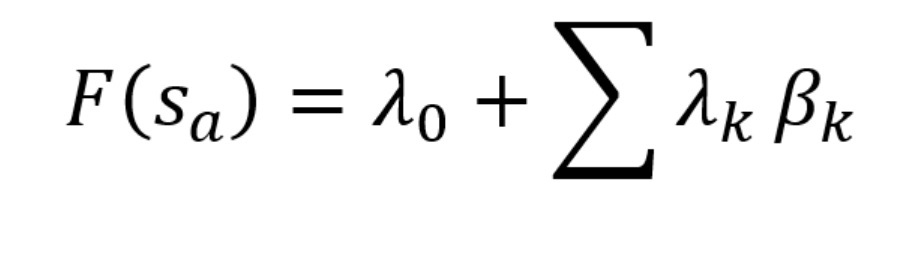

In [9]:
from PIL import Image
Image.open("linear_reg.jpg")

stk_bnc_hist.csv에서 act_id를 기준으로 groupby를 해서 count를 진행해,
고객별 주식 매수 매도 횟수를 카운팅 해서 buy_sell_cnt 변수를 생성 했다.

하지만 stk_bnc_hist에 존재하지 않는 고객이 cus_info.csv에 존재해서,
해당 고객들의 주식 매수 매도 횟수는 카운팅 할 수 가 없어,
linear regression model을 사용해서 예측을 해서 값을 넣어주었다.

이때 사용한 베타값들은 sex_dit_cd, cus_age_Stn_cd, ivs_icn_cd,
cus_aet_stn_cd, mrz_pdt_tp_sgm_cd, lsg_sgm_cd, tco_cus_grd_cd,
tot_ivs_te_sgm_cd, mrz_btp_dit_cd을 사용해 buy_sell_cnt를 예측했다.

이와 같은 이유로 stk_bnc_hist에서 최초 매수일, 마지막 매도일의 차로 고객별
주식 기간을 구해서 total_date라는 변수를,
고객별 거래 업종을 카운팅해, 가장 상단에 위치한 업종을 고객의 선호 매수 종목으로
저장해준 btp_cfc_cd 변수를,
stk_bnc_hist에 존재했지만 cus_info에 존재하지 않아서 값을 넣어줄 수 없었던 
total_date와 btp_cfc_cd 데이터를 linear regression을 사용해 예측해 주었습니다.

사용한 변수들은 위와 동일합니다.

### A. 채택된 변수에 대한 설명 

In [3]:
import pandas as pd

cus_info=pd.read_csv('data/cus_info.csv')

In [4]:
cus_info.head()

,act_id,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd
0,64aae8dd71e5c0761000db9f9a6779e504e7a4aa9dc097...,1,4,99,1,2,3,3,6,16
1,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,1,6,4,4,2,5,2,6,1
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,2,7,4,3,2,5,5,6,9
3,6d497facfa1ea5901b827335553331f8555fec02a8184f...,2,6,4,4,8,5,3,6,16
4,b727c78d2cfc246c97b677f29a034399a0c7e7873fff44...,1,5,2,2,2,5,5,5,16


In [3]:
cus_info.columns

Index(['act_id', 'sex_dit_cd', 'cus_age_stn_cd', 'ivs_icn_cd',
       'cus_aet_stn_cd', 'mrz_pdt_tp_sgm_cd', 'lsg_sgm_cd', 'tco_cus_grd_cd',
       'tot_ivs_te_sgm_cd', 'mrz_btp_dit_cd'],
      dtype='object')

### A-1. 기존 변수 채택

#### A-1-1. cus_info.csv

act_id는 train, test 간 연결해주기 위한 primary key로 사용되어 채택하였다.

findfont: Font family ['NanumSquareRound'] not found. Falling back to DejaVu Sans.


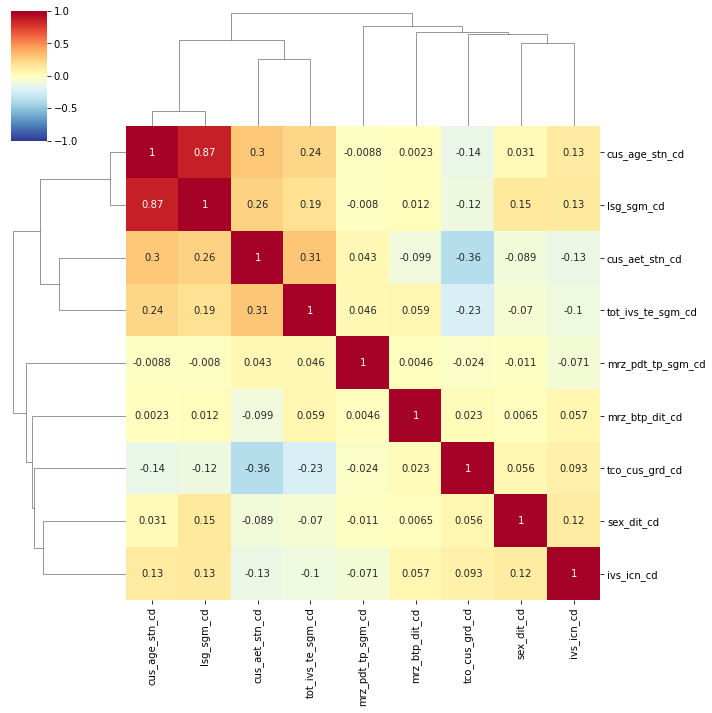

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = cus_info.corr()

sns.clustermap(df, 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

cus_age_stn_cd와 lsg_sgm_cd의 양의 상관관계가 매우 높게 나와서 lsg_sgm_cd feature을 삭제하고 cus_age_stn_cd을 채택하였다.

tco_cus_grd_cd와 cus_aet_stn_cd의 음의 상관관계가가 높게 나와 tco_cus_grd_cd feature을 삭제했다.

In [5]:
cus_info.drop(['lsg_sgm_cd'],axis=1,inplace=True)
cus_info.drop(['tco_cus_grd_cd'],axis=1,inplace=True)

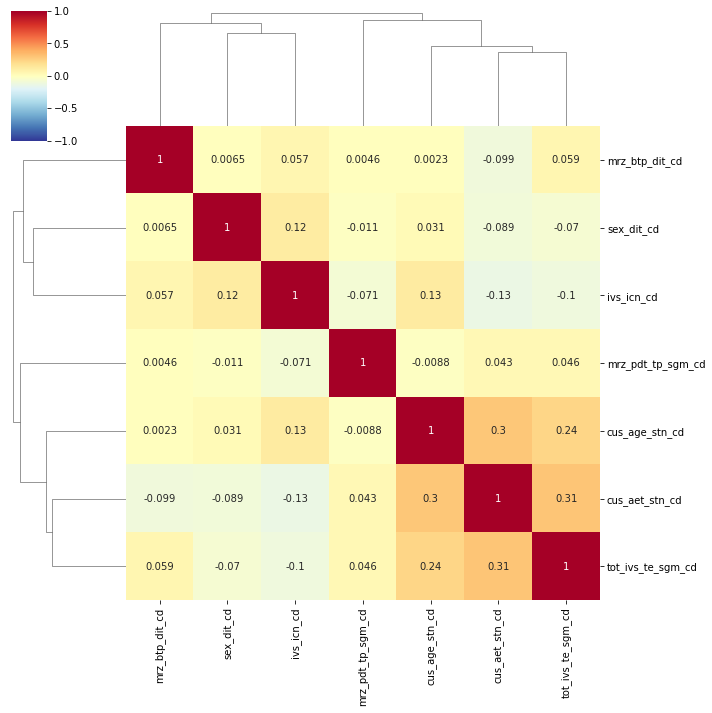

In [6]:
df = cus_info.corr()

sns.clustermap(df, 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

In [7]:
cus_info.groupby('sex_dit_cd')['ivs_icn_cd'].value_counts().to_frame()

ivs_icn_cd
sex_dit_cd ivs_icn_cd            
1          99                1915
           4                 1263
           3                 1056
           2                  833
           5                  717
           1                  104
           0                   94
           9                    3
2          99                1772
           2                  634
           3                  613
           4                  595
           5                  218
           1                  106
           0                   77

sex_dit_cd는 고객 별 성별 데이터로, ivs_icn_cd와 연관성을 위의 clustermap에서 파악할 수 있었다. 

그래서 성별에 투자성향이 미정의:99 를 제외한 나머지 성향에서 여성과 남성이 차이가 있음을 알수 있어 두 변수를 채택하였다.

In [8]:
cus_info.groupby('tot_ivs_te_sgm_cd')['cus_aet_stn_cd'].value_counts().to_frame()

cus_aet_stn_cd
tot_ivs_te_sgm_cd cus_aet_stn_cd                
1                 1                          721
                  2                          147
                  3                           41
                  4                           36
                  5                           16
                  6                            1
2                 1                         1276
                  2                          995
                  3                          391
                  4                          362
                  5                          224
                  6                           67
3                 1                         1312
                  2                         1268
                  4                          562
                  3                          519
                  5                          457
                  6                          153
4                 2                          243
                  1                          206
                  4                          173
                  5                          161
                  3                          139
                  6                           70
5                 5                           81
                  2                           59
                  4                           58
                  1                           45
                  3                           40
                  6                           29
6                 5                           45
                  4                           31
                  2                           28
                  3                           17
                  6                           15
                  1                           12

tot_ivs_te_sgm_cd는 총 투자기간을 나타내는 변수로, cus_aet_stn_cd인 고객자산구간과 연관성을 위의 clustermap에서 파악할 수 있었다. 

그래서 총 투자기간에 따른 고객 자산 구간을 확인해 본 결과, 총 투자기간인 5,6(5년 이상)에서는 1억원 이상의 총 자산금액이 있다는 것을 파악 하였고 그 미만 투자기간에서는 1천만원 이상 3천만원 미만의 총 자산금액이 있음을 파악하여 두 변수를 채택하였다.

In [9]:
cus_info['mrz_pdt_tp_sgm_cd'].to_frame().value_counts()

mrz_pdt_tp_sgm_cd
2                    9659
3                     261
1                      34
15                     10
10                      9
8                       8
5                       7
9                       5
11                      3
6                       3
12                      1
dtype: int64

mrz_pdt_tp_sgm_cd는 주거래 상품군으로, 2인 국내주식이 가장 많았어서 국내와 그 외 주식별로 차이가 있을 것이라 생각되어 채택하였다.

mrz_btp_dit_cd는 주거래 업종구분으로, 개인별 act_id에 따른 주거래 업종 구분을 파악하기 위해 채택하였다.

#### A-1-2. iem_info_20210902.csv

In [5]:
iem_info=pd.read_csv('data/iem_info_20210902.csv')

In [6]:
iem_info.head()

,iem_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd
0,A000020,동화약품,8,2,99
1,A000080,하이트진로,14,2,1
2,A000180,성창기업지주,5,3,99
3,A000227,유유제약2우B,8,99,99
4,A000325,노루홀딩스우,2,99,99


iem_krl_nm은 업종명을 한국어로 한것이며, mkt_pr_tal_scl_tp_cd는 시가총액규모유형이고, stk_dit_cd은 시장구분이다.

이 3개의 변수로 종목정보와 고객정보를 매칭시켜 고객의 투자 유형을 판단할 수 있을 것이라고 생각하여 채택하였다.

#### A-1-3. stk_bnc_hist.csv

In [7]:
cus_info=pd.read_csv('data/stk_bnc_hist.csv')
cus_info.head()

,act_id,bse_dt,iem_cd,bnc_qty,tot_aet_amt,stk_par_pr
0,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200820,A008770,40.0,2828000.0,5000.0
1,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A008770,20.0,1390000.0,5000.0
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20160104,A005940,311.0,2982490.0,5000.0
3,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200814,A005930,40.0,2320000.0,100.0
4,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A005930,20.0,1028000.0,100.0


bnc_qty는 잔고수량을 의미하고, tot_aet_amt는 잔고금액을 의미하고, stk_par_p는 액면가를 의미한다. 

그래서 act_id로 cus_info에 있는 연결해 개인별 국내주식 잔고이력을 파악할 수 있어 3개의 변수를 채택하였다.

### A-2. 파생 변수 생성

yield 변수는 (구매일자의 주가 / 판매일자의 주가) 의 식을 사용하여 파생한 변수이다.

buy_sell_quant는 cus_info.csv에서 파생한 변수로 (매도 매수 횟수 / 마지막 매도일 - 첫 매수일) -> 10분위로 나눠서 0~1 값으로 정규화 한 변수이다.

best_btp는 iem_info_20210902.csv에서 파생한 변수로 고객별 선호 업종을 나타낸다.

btp_cfc_cd_x은 iem_info_20210902.csv에서 파생한 변수로 고객별 가장 많이 산 종목을 나타낸다.

total은 총 수익나타내는 변수로, stk_bnc_hist.csv에서 파생한 변수이다.

stk_p는 주식 주당 가격을 나타낸 변수이다.

### B. 분석의 범주

train에서 hist_d를 좋은 값으로 예측하는것이라고 판단하여, train의 hist_d를 예측하는것을 1차 타겟, 
해당 hist_d를 추가시켜 hold_d로 학습시킨 후, 최종적으로 test의 hist_d로 hold_d를 예측하는것을 2차 타겟으로 잡았다.

train 데이터에서 약 68만건 데이터중 58만건 데이터의 hold_d가 30일 미만에 존재했다.

그에 비해 test 데이터는 hold_d보다 값이 작아야 되는 hist_d 기준인데도 불구하고,
1/3 데이터만이 30일 미만에 존재했습니다. 이러한 언벨런싱한 데이터를 학습시켜서, test를 예측하게 되면 안좋은 결과가 나올 것 이라고 판단하여 모델을 30일 미만 데이터와 30일 이상 데이터로 나누어, 2가지 모델로 학습과 예측을 진행하게 되었다.

### C. 모델링 진행 및 중요한 가정들

고객의 총 수익을 나타내는 total데이터의 경우 값의 분포가 너무나 커서 학습 저하 우려가 있어,
quantile함수를 사용해 백분위수로 치환해서 사용을 하였다.

고객의 매도, 매수 횟수를 저장한 plus, minus변수는 overfitting이 너무 심해 모델에 악영향을 끼친다는
가정을 세우고, drop시킨 후 학습시키자 rmse가 줄어드는 모습을 보여 최종적으로 drop을 시켜주었다.

lsg_sgm_cd와 cus_age_stn_cd변수의 상관관계가 0.86,
tco_cus_grd_cd와 cus_aet_stn_cd변수의 상관관계가 -0.6의
분포를 지니고 있어서 데이터간 독립성을 위배해서 모델 학습의 악영향을 끼친다는 가정을 세우고,
drop을 진행 해 봤고, rmse가 줄어드는 모습을 보여 최종적으로 drop을 진행했다.

모델은 lgbm모델을 최종적으로 선정하였으며, 약 7정도의 rmse를 가지는 것을 파악하였다.

### D. 모델링에 대한 추가적인 특이사항

해당 모델은 30일 전 후 로 모델을 2개로 나눠서 학습, 예측을 진행 하고 있어 최종적인 결과값은 합쳐진 하나의 데이터셋 이지만, 모델을 사용하는 구간에 있어서는 30일 전 후, 2개의 결과값으로 나누어서 나오게 된다.

## 2. 외부 데이터에 대한 설명

##### open.csv
공휴일을 제외한 주식시장 날짜를 가져오기 위해 https://kr.investing.com/holiday-calendar/ 을 참고하여 추출하였다.

수집은 복사를 하여서 list저장 하였고, csv로 바꿔주는 작업을 했다.

전처리는 따로 하지 않고, 주식시장 날짜와 일반 날짜가 다르기 때문에 이 데이터를 활용했다.

##### 주가정보_2016_2021.csv
날짜별 주식들의 주가정보를 가져오기 위해 https://github.com/sharebook-kr/pykrx의 pykrx api를 사용하였다.

이 api를 활용하여 날짜별 주가정보를 받아왔다.

파생된 변수인 yield 변수 (구매일자의 주가 / 판매일자의 주가) 를 사용해서 주가 데이터를 사용하기 위해 이 데이터를 활용했다.

자세한 이유와 코드는 알고리즘 설명서를 참고하면 알 수 있다.